# 2.8 - Weights initialization

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False);


## follow the explanation here

[https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/](https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
%matplotlib inline
import tensorflow as tf
tf.__version__

'2.19.0'

In [3]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print(X_train.shape, y_train_oh.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)
(1200, 784) (1200, 10)


## load data and train a simple model

In [7]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32')

In [78]:
def get_model(input_dim=784, output_dim=10, layer_sizes=[10]*6, activation="relu", sigma=1):
    inputs = Input(shape=(input_dim,))

    init1k = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)
    init1b = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)

    layer = Dense(layer_sizes[0], activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0),
                    kernel_initializer=init1k,
                    bias_initializer=init1b,
                    dtype=tf.float64
                )(inputs)

    layers = [inputs, layer]
    for i, hsize in enumerate(layer_sizes[1:]):
        layer = Dense(hsize, activation=activation, name="Layer_%02d_Hidden"%(i+1), dtype=tf.float64)(layer)
        layers.append(layer)

    outputs = Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(len(layer_sizes)), dtype=tf.float64)(layer)

    layers.append(outputs)

    model = Model([inputs], [outputs])

    model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return model, layers

def get_gradients_functions(layers):
    T_input     = layers[0]
    T_outputs   = layers[1:]
    T_weights   = model.trainable_weights

    F_outputs = None
    F_outputs   = [Model(model.input, [out]) for out in T_outputs]

    def get_gradients_functions(model):
        r = []
        for i in range(len(model.trainable_variables)):
            def f(X,y,i=eval("i")):
                v = model.trainable_variables[i]
                with tf.GradientTape(persistent=True) as t:
                    loss = model.loss( model(X), y)
                return t.gradient(loss,v).numpy()
            r.append(f)
        return r

    F_gradients = get_gradients_functions(model)

    return T_input, T_outputs, T_weights, F_outputs, F_gradients

In [37]:
model, layers = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=20)
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_00_Input (Dense)          │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_01_Hidden (Dense)         │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_02_Hidden (Dense)         │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_03_Output (Dense)         │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,415 (128.24 KB)

 Trainable params: 16,415 (128.24 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.get_config()

{'name': 'functional_18',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 784),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input'},
   'registered_name': None,
   'name': 'input',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'Layer_00_Input',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float64'},
     'registered_name': None},
    'units': 20,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomNormal',
     'config': {'seed': None, 'mean': 0.0, 'stddev': 20},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomNormal',
     'config': {'seed': None, 'mean': 0.0, 'stddev': 20},
     'registered_name': None

In [41]:
T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(layers)

In [52]:
(-shift_X)

-0.5

In [53]:
scale_X=.2
shift_X =.5
!rm -rf log
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/winit', histogram_freq=1,  write_graph=True, write_images=True)
model.fit((X_train-shift_X)*scale_X, y_train_oh, epochs=30, batch_size=32,
          validation_data=((X_test-shift_X)*scale_X, y_test_oh),
         )#callbacks=[tb_callback])




Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0850 - loss: 2.5021 - val_accuracy: 0.1033 - val_loss: 2.3299
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1063 - loss: 2.3428 - val_accuracy: 0.1033 - val_loss: 2.2992
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0879 - loss: 2.3143 - val_accuracy: 0.0967 - val_loss: 2.2909
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1268 - loss: 2.2931 - val_accuracy: 0.1200 - val_loss: 2.2884
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1319 - loss: 2.2814 - val_accuracy: 0.1033 - val_loss: 2.2885
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1289 - loss: 2.2806 - val_accuracy: 0.1033 - val_loss: 2.2863
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1460 - loss: 2.2638 - val_accuracy: 0.1033 - val_loss: 2.2823
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1229 - loss: 2.2705 - val_accuracy: 0.1033 - val_loss

## Effects of different initializations

understand carefully the following function

check the notebook on **Inspecting model internals** to understand `get_tensors_and_functions` and the objects it returns

In [84]:
def train_experiment(model, layers, sigma, X_train, X_test):
    T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(layers)

    w0_before = model.get_weights()[0].reshape(-1)
    o0_before = F_outputs[0]([X_train])[0].reshape(-1)
    g0_before = F_gradients[0](X_train, y_train_oh).reshape(-1)

    model.fit(X_train, y_train_oh, epochs=30, batch_size=32,
              validation_data=(X_test, y_test_oh), verbose=0)

    w0_after = model.get_weights()[0].reshape(-1)
    o0_after = F_outputs[0]([X_train])[0].reshape(-1)
    g0_after = F_gradients[0](X_train, y_train_oh).reshape(-1)

    acc, val_acc = model.history.history["accuracy"], model.history.history["val_accuracy"]

    plt.figure(figsize=(20,3))
    plt.subplot(141)
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="test_acc")
    plt.legend();
    plt.grid()
    plt.title("sigma=%.2f"%(sigma))
    plt.xlabel("epoch")
    plt.subplot(142)
    plt.hist(w0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(w0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 weights")

    plt.subplot(143)
    plt.hist(o0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(o0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 outputs")

    plt.subplot(144)

    def get_percentile(k, perc=90):
        p = np.percentile(np.abs(k), [perc])[0]
        return k[(k>-p)&(k<p)]

    plt.hist(get_percentile(g0_after), bins=30, density=True, label="after", alpha=.5);
    plt.hist(get_percentile(g0_before), bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 gradients")

### initializing with a standard normal ($\mu=0$ and $\sigma=1$)

histograms show weights, outputs and gradients before and after training

in good configurations:
- weights move during training
- gradients are spread around zero before training
- outputs before training are spread

In [85]:
model, layers = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=1.)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_117']
Received: inputs=Tensor(shape=(1200, 784))
  warnings.warn(msg)


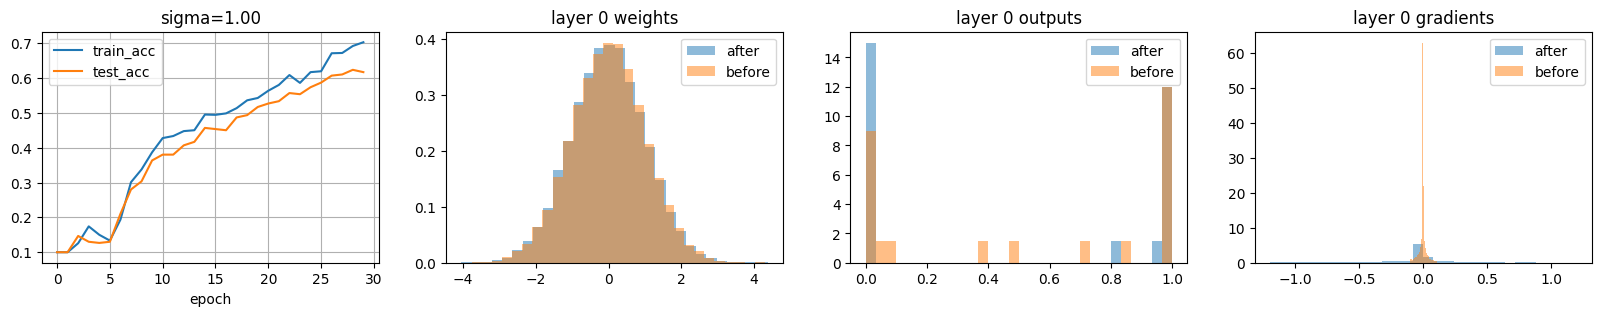

In [86]:
train_experiment(model, layers, sigma=1, X_train=X_train, X_test=X_test)

### initializing with a small $\sigma$


In [87]:
sigma= 0.1
model, layers = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=sigma)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_123']
Received: inputs=Tensor(shape=(1200, 784))
  warnings.warn(msg)


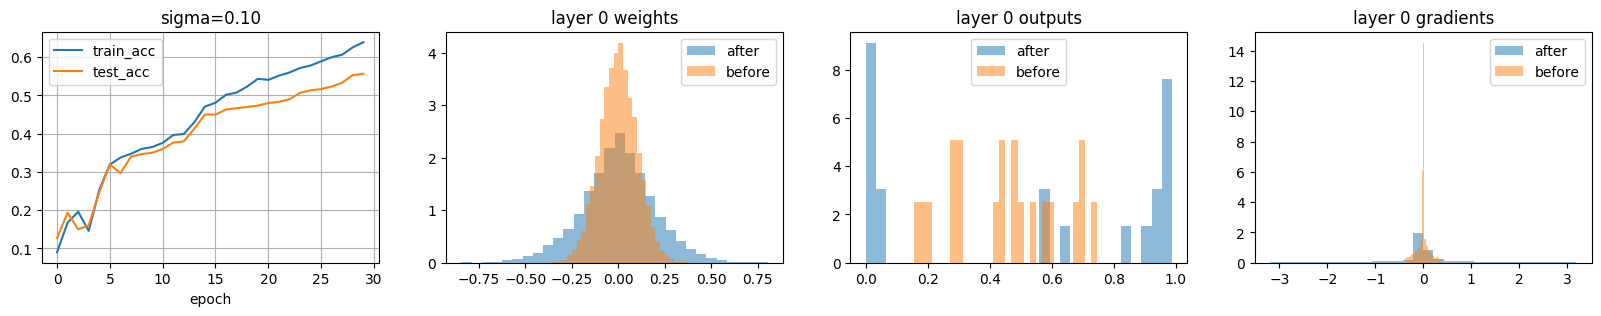

In [88]:
train_experiment(model, layers, sigma=sigma, X_train=X_train, X_test=X_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_129']
Received: inputs=Tensor(shape=(1200, 784))
  warnings.warn(msg)


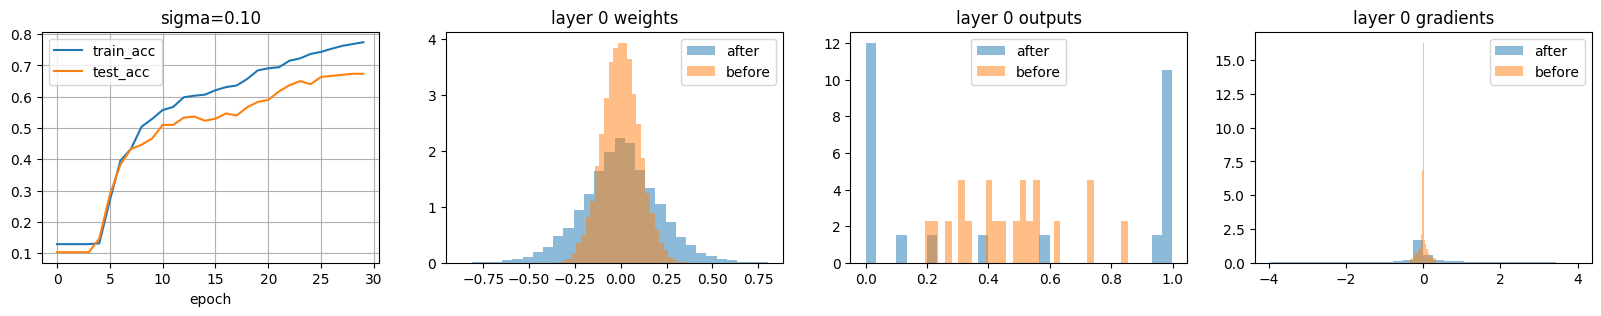

In [89]:
sigma= 0.1
model, layers = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=sigma)
train_experiment(model, layers, sigma=sigma, X_train=X_train, X_test=X_test)

### initializing with a large $\sigma$

observe how gradients are very concentrated arounz zero at the beginning of training

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_135']
Received: inputs=Tensor(shape=(1200, 784))
  warnings.warn(msg)


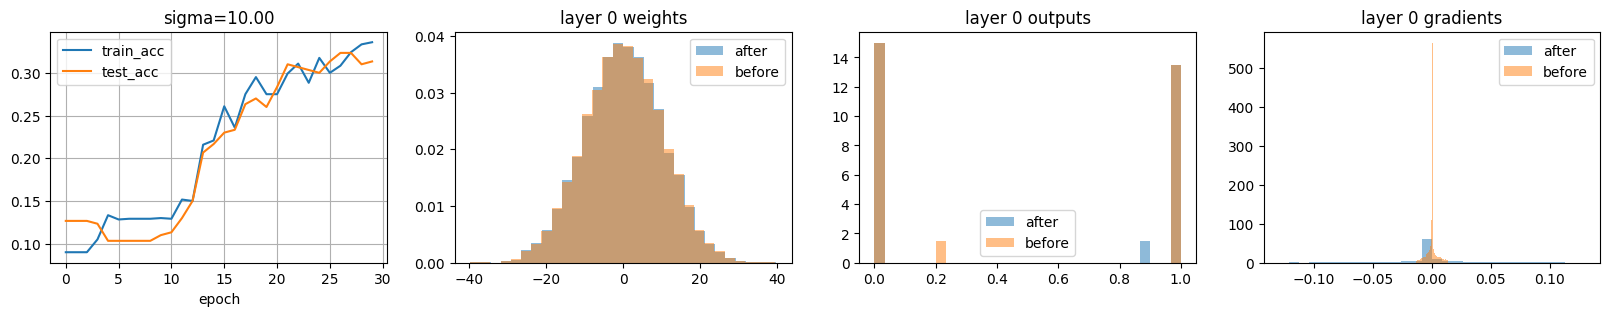

In [90]:
sigma= 10
model, layers = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=sigma)
train_experiment(model, layers, sigma=sigma, X_train=X_train, X_test=X_test)

### initializing with a small $\sigma$ but with large values for input data

Recall that $XW+b$ is what enters the $sigmoid$ function. If large, it will be away from the linear regine around zero. It can be large because of $W$ (large initialization $\sigma$), or because of $X$.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_147']
Received: inputs=Tensor(shape=(1200, 784))
  warnings.warn(msg)


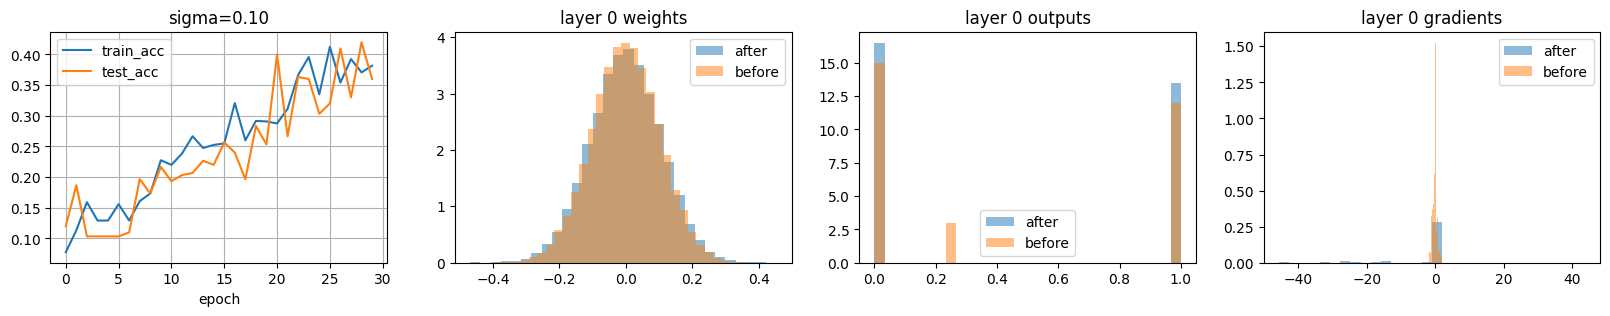

In [92]:
sigma= 0.1
model, layers = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=sigma)
train_experiment(model, layers, sigma=sigma, X_train=X_train*100-50, X_test=X_test*100-50)